# Notæ 1
## Modelado y resolución de PLE en Python

### Introducción

El objetivo de este primer notebook introductorio es aprender a escribir modelos de Programación Lineal Entera (PLE) en Python y resolverlos por medio de CPLEX. 

Vamos a seguir el <a href="https://en.wikipedia.org/wiki/Eight_queens_puzzle">Problema de las N Reinas</a> como caso de estudio, en su versión de problema de optimizaión. 

#### Problema de las $N$ reinas
<i>Entrada:</i> Un número natural $N \geq 4$.<br>
<i>Objetivo:</i> Ubicar la mayor cantidad de reinas en las casillas de un tablero de ajedrez de tamaño $N \times N$ inicialmente vacío, de modo que ningún par de reinas se ataque mutuamente (recordar que dos reinas se atacan si se encuentran en una misma fila, columna o diagonal).

Python dispone de un paquete llamado <code>chess</code> que nos permite fácilmente graficar tableros y piezas de ajedrez (si... python tiene infinidad de cosas, algunas más útiles que otras &#128514;). Este paquete nos vendrá bien para mostrar un ejemplo de colocación. En este caso, se coloca una reina en la casilla "c6" y se muestran en rojo las casillas atacadas. No se preocupen por entender el código de abajo, simplemente ejecútenlo y vean en resultado. Obviamente mientras sea posible, deberemos seguir colocando reinas en las casillas restantes. Más adelante volveremos a usar este paquete para graficar soluciones del problema.

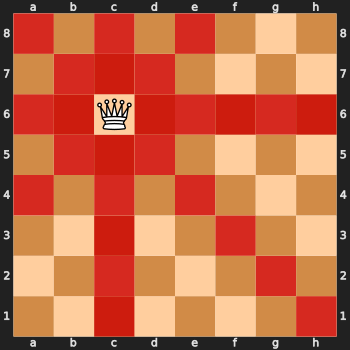

In [19]:
import chess

board = chess.Board()
board.clear()
board.set_piece_at(chess.C6, chess.Piece(chess.QUEEN, chess.WHITE))
chess.svg.board(board, fill=dict.fromkeys(board.attacks(chess.C6), "#cc0000cc"), size=350)

### Formulación de PLE

Una forma de resolver este problema es modelarlo con PLE y luego resolverlo con un solver de PLE de propósito general, como CLEX. De este enofque nos ocuparemos a lo largo del notebook, pero tener presenten que existen muchos otros enfoques (backtracking, constraint programming, etc.). De todas formas, siempre que nos enfrentemos a un problema nuevo, es recomendable formularlo como PLE, ganaremos un mayor entendimiento del mismo y quizás se revelen detalles sobre su estructura.

En general, un mismo problema puede ser formulado como PLE de diferentes formas, y las reinas no son una excepción. Una de las formulaciones más sencillas surge de observar la siguiente condición suficiente y necesaria para ser solución: <i>el número de reinas en cada fila/columna/diagonal debe ser a lo sumo uno.</i>

#### Variables

Para simplificar la redacción, notaremos $\mathcal{N} = \{0\ldots,N-1\}$. Para cada $(i,j) \in \mathcal N \times \mathcal N$, definimos una variable binaria
$$ x_{i,j} = \begin{cases} \displaystyle
  1 & \text{ si hay una reina en la casilla } (i,j), \\
  0 & \text{ en caso contrario.}
\end{cases}$$
En este caso, $x_{0,0}$ se corresponde con la casilla "a1", $x_{0,1}$ con "b1", y así sucesivamente. Esta simplificación es necesaria porque en programación los arreglos están indexados con números naturales comenzando desde el 0. Más adelante volveremos a hablar de esto cuando grafiquemos las soluciones.

#### Función objetivo
Debemos maximizar el número de reinas colocadas, es decir:
$$\max \sum_{(i,j) \in \mathcal N \times \mathcal N} x_{i,j} $$

#### Restricciones

* En cada fila hay a lo sumo una reina:
$$ \sum_{j \in \mathcal N} x_{i,j} \leq 1,~~~ \forall\ i \in \mathcal N. $$

* En cada columna hay a lo sumo una reina:
$$ \sum_{i \in \mathcal N} x_{i,j} \leq 1,~~~ \forall\ j \in \mathcal N. $$

* En cada diagonal hay a lo sumo una reina. Para no complicar demasiado estas restricciones, supongamos que $\mathcal D$ es el conjunto de todas las diagonales de largo al menos 2. Es decir, cada $D \in \mathcal D$ contiene todas las casillas que se encuentran en una misma diagonal. Por ejemplo, la diagonal a 45º que inicia en "a1" es $\{(k,k): k \in \mathcal N\}$, la inmediata superior que inicia en "a2" es $\{(1+k,k): k \in \mathcal N \setminus \{7\} \}$, y así sucesivamente. Luego podemos escribir estas restricciones como:
$$ \sum_{(i,j) \in D} x_{i,j} \leq 1,~~~ \forall\ D \in \mathcal D. $$
Notar que no consideramos diagonales con una única casilla porque dichas restricciones están implicadas por la binaridad de las variables.

En total hay $N^2$ variables y $4N-6$ restricciones.

### Modelado en python

Una vez escrito el modelo en lápiz y papel, lo siguiente es pasarlo a python. 

Los primeros pasos son de inicialización y nunca deben faltar. Comenzamos importando los paquetes necesarios para llamar a CPLEX.

In [80]:
# Comenzamos solicitando los paquetes necesarios.
import cplex
from docplex.mp.model import Model

A continuación llamamos al constructor de la clase <code>Model</code> para construir un objeto que contendrá toda la información de nuestro modelo. En este paso podemos especificar un nombre para nuestro modelo mediante el atributo de clase <code>name</code>. Finalmente guardamos el modelo en una variable de python (no confundir con variable del modelo) de nombre <code>modelo</code> para referenciarlo más adelante. 

In [125]:
# Ahora creamos el modelo.
modelo = Model(name='queens')

Lo siguiente es empezar a poblar el modelo con las variables, la función objetivo y las restricciones. Comencemos 
por las variables...

Primero vamos a definir variables de python para almacenar a $N$ y $\mathcal N$:

In [126]:
N = 8 # 8 reinas
NN = range(8) ## NN = {0,...,7} 

Es hora de las variables. Vamos a guardar en una variable de python de nombre <code>X</code> una matriz de tamaño $N \times N$. Inicialmente esta matriz estará vacía, es decir, rellena de 0's. Iterativamente la iremos poblando con las variables del modelo. El método <code>binary_var()</code> de la clase <code>Model</code> se usa para construir una variable del modelo. Aunque no es necesario, es recomendable darle un nombre a cada variable del modelo mediante el atributo <code>name</code>, lo que nos facilitará su interpretación una vez resuelto el modelo. En este caso, a la variable $x_{i,j}$ le daremos el nombre 'x_i_j'.

In [127]:
X = [[0 for i in NN] for j in NN] # Matriz de tamaño NxN
# Rellenamos la matriz con las variables del modelo
for i in NN:
    for j in NN:
        X[i][j] = modelo.binary_var(name='x_' + str(i) + '_' + str(j))

Para los más experimentados en python, las 3 líneas de arriba se pueden escribir en una única, de la siguiente forma. La dejamos comentada para no pisar las variables.

In [128]:
# X = [[modelo.binary_var(name='x_'+ str(i) + '_' + str(j)) for i in NN] for j in NN]

Podemos verificar que en las casillas de <code>X</code> están efectivamente las variables del modelo. Por ejemplo en la (0,0) está 'x_0_0'.

In [129]:
print(X[0][0])

x_0_0


HASTA ACÁ LLEGUÉ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#### Las variables de decisión son:
- x[i,j] = 1 si se coloca una reina en la posicion (i,j), 0 si no, para todo i, j en T

#### La función objetivo es:
- max sum_ij x[i,j]

#### Y las restricciones son:
- Para dada una posición (i,j), colocar una reina en esa posición impide la colocación de una reina en cualquier otra posición tanto en sentido horizontal (es decir, otra (k, j) con k en T-{i}) como vertical (es decir, otra (i, k) con k en T-{j}) como diagonal, la que se puede modelar como una big-M, por ejemplo para (1,1) tenemos:
50 x[1,1] + x[1,2] + x[1,3] + x[1,4] + x[1,5] + x[1,6] + x[1,7] + x[1,8] + x[2,1] + x[2,2] + x[3,1] + x[3,3] + x[4,1] + x[4,4] + x[5,1] + x[5,5] + x[6,1] + x[6,6] + x[7,1] + x[7,7] + x[8,1] + x[8,8] <= 50

In [101]:
# Conjuntos útils
T = range(1, 9)    # T = {1, 2, ..., 8}
S = {k for k in range(-7, 8) if k != 0} # S = {-7, -6, ..., -1, 1, 2, ..., 7}

# Creamos las variables
x = {(i,j): m.binary_var(name='x_{0}_{1}'.format(i,j)) for i in T for j in T}

# Creamos la función objetivo
m.maximize(m.sum(x[i,j] for i in T for j in T))

# Listamos las restricciones
for i in T:
    for j in T:
        m.add_constraint(50 * x[i,j]
                         + m.sum(x[k,j] for k in T if k != i)
                         + m.sum(x[i,k] for k in T if k != j)
                         + m.sum(x[i+k,j+k] for k in S if i+k in T and j+k in T)
                         + m.sum(x[i+k,j-k] for k in S if i+k in T and j-k in T) <= 50)

# Observamos algunos datos (deberían ser 64 variables y 64 restricciones)
m.print_information()

Model: queens
 - number of variables: 64
   - binary=64, integer=0, continuous=0
 - number of constraints: 64
   - linear=64
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


In [26]:
# Para revisar que el modelo esté ok, podemos exportarlo a un archivo y revisarlo con un editor.
m.export_as_lp("modelito.lp")

'modelito.lp'

In [27]:
# Resolvemos y mostramos la solución numérica

sol = m.solve(log_output=True)
print('')
if sol is None:
    print('El modelo es infactible!')
else:
    print('Solución:')
    sol.display()

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.01 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve modified 540 coefficients.
Reduced MIP has 64 rows, 64 columns, and 1520 nonzeros.
Reduced MIP has 64 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (1.42 ticks)
Probing time = 0.00 sec. (0.86 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 64 rows, 64 columns, and 1520 nonzeros.
Reduced MIP has 64 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.88 ticks)
Probing time = 0.00 sec. (0.86 ticks)
Clique table members: 855.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.00 sec. (1.18 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Be

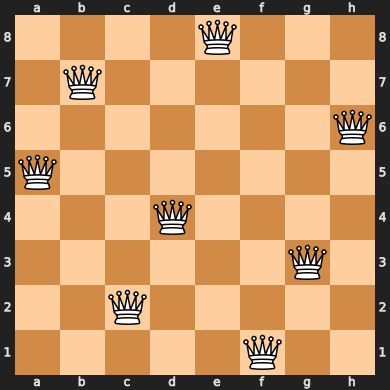

In [28]:
# Veamos la solución en un Tablero
board = chess.Board()
board.clear()
for i in T:
    for j in T:
        if sol.get_value(x[i,j]) > 0.5:
            squareIndex=i*8+j-9
            board.set_piece_at(chess.SQUARES[squareIndex], chess.Piece(chess.QUEEN, chess.WHITE))
board

#### Actividades:
- Añada una restricción que obligue a colocar una posición en algún lugar fijo del tablero. ¿Sigue siendo 8 la solución óptima? ¿Puede forzar a que sea inferior a ese número?
- Añada una o varias restricciones para tornar al modelo infactible y compruébelo.
- ¿Se anima a re-escribir el modelo como un Problema del Conjunto Estable, es decir reemplazando las actuales restricciones por otras de la forma x[i,j] + x[k,l] <= 1 (formulación EDGE)?


    * Diagonal a 45º que inicia en la casilla (i,0):
    $$ \sum_{k = 0}^{N-1-i} x_{i+k,k} \leq 1,~~~ \forall\ i \in \mathcal N \setminus \{7\}$$
    * Diagonal a 45º que inicia en la casilla (0,j):
    $$ \sum_{k = 0}^{N-1-j} x_{k,j+k} \leq 1,~~~ \forall\ j \in \mathcal N \setminus \{0,7\}. $$
    * Diagonal a -45º que inicia en la casilla (i,0):
    $$ \sum_{k = 0}^{i} x_{i-k,k} \leq 1,~~~ \forall\ i \in \mathcal N \setminus \{0\}. $$
    * Diagonal a -45º que inicia en la casilla (7,j):
    $$ \sum_{k = 0}^{N-1-j} x_{7-k,j+k} \leq 1,~~~ \forall\ j \in \mathcal N \setminus \{0,7\}. $$